# Filler-Gap Dependencies with GPT-2 (English)

Created Feburary 2023 by [Forrest Davis](https://conf.ling.cornell.edu/forrestdavis/). Get in touch if you have any questions!

The following colab script attempts to replicate some of the experiments in [Wilcox et al. (2022)](https://direct.mit.edu/ling/article/doi/10.1162/ling_a_00491/113304/Using-Computational-Models-to-Test-Syntactic) with materials I can find from their other projects. If you've never used colab before, [here](https://colab.research.google.com) is a nice introductory document. It links to this, sort of unsettling, [video](https://www.youtube.com/watch?v=inN8seMm7UI).  

What's critical for this notebook is running code. You can run code by hovering over "code blocks" and pressing the play button to the left. 



In [ ]:
# Push the play button to the left
print('hello')

hello


# Setting up

The code blocks in this section do the following: 

1. Install the necessary packages
2. Import the libraries
3. Clone the data repo I made
3. Clone a repo I made for evaluating models
4. Move into the evaluation git repo

In [110]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Exception ignored in: <function _get_module_lock.<locals>.cb at 0x7f06c6c893a0>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 176, in cb
KeyboardInterrupt: 
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/autocompletion.py", line 12, in <module>
    from pip._internal.metadata import get_default_environment
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/metadata/__init__.py", line 3, in <module>
    from .base import BaseDistribution, BaseEnvironment, FilesystemWheel, MemoryWheel, Wheel
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/metadata/base.py", line 21, in <module>
    from pip._vendor.packaging.requirements import Requi

In [111]:
import transformers
import torch
import pandas as pd
import sentencepiece

In [112]:
# Clone my data repo
!git clone https://github.com/DavisLingTeaching/TopicsCL.git
# Clone the evaluation repo
!git clone https://github.com/forrestdavis/PublicModelsAPI.git

fatal: destination path 'TopicsCL' already exists and is not an empty directory.
fatal: destination path 'PublicModelsAPI' already exists and is not an empty directory.
/content/PublicModelsAPI


# Basic Licensing

The paper explores three syntactic frames initially:

1. Subject gaps 
2. Object gaps
3. Prepositional phrase gaps

I could not find their data, so instead I drew on a paper which cites another paper of theirs. Namely, [Hu et al. (2020)](https://www.aclweb.org/anthology/2020.acl-main.158). The data are similar, though there are less and the sentences from their paper are not in it.

In [108]:
#@title Basic Code
def getBasic(modelType='gpt2', modelName='gpt2'):
    # set path
    import sys
    import json
    sys.path.append("/content/PublicModelsAPI/")
    from src.models import models

    run_config = {'models': {modelType: [modelName]}}

    LM = models.load_models(run_config)[0]
    
    RESULTS = {'exp': [], 'item': [], 'cond': [], "wh-effect":[]}

    # Subject gap
    data = pd.read_csv("/content/TopicsCL/data/Wilcox/fgd_subject.csv")

    #fill in nans
    data.fillna('', inplace=True)

    conditions = list(set(data['condition_name'].tolist()))
    # [(3;%what_nogap%) > (3;%that_nogap%) ] & 
    # [(4;%what_gap%) < (4;%that_gap%)]
    for index in range(1, max(data['item_number'])+1):
        vals = {}
        subset = data[data['item_number'] == index]

        for cond in conditions:

            targetRegion = 4
            if '_nogap' in cond:
                targetRegion= 3

            sentData = subset[subset['condition_name'] == cond]
            words = sentData['content'].tolist()
            regions = sentData['region_number'].tolist()
            assert len(words) == len(regions)
            regions = list(zip(regions, words))
            sent = ' '.join(words).replace('  ', ' ')
            # Get by word surprisals
            surps = LM.get_aligned_words_surprisals(sent)[0]
            
            # Group into regions
            total = 0
            for region in regions:
                r, words = region
                if words == '':
                    continue
                for word in words.split(' '):
                    surp = surps.pop(0)
                    assert surp.word == word
                    if r == targetRegion:
                        total += surp.surp
            vals[cond] = total

        gap_wh_effect = vals['what_gap'] - vals['that_gap']
        nogap_wh_effect = vals['what_nogap'] - vals['that_nogap']

        RESULTS['item'].append(index)
        RESULTS['item'].append(index)

        RESULTS['exp'].append('subject')
        RESULTS['exp'].append('subject')

        RESULTS['cond'].append('+gap')
        RESULTS['cond'].append('-gap')

        RESULTS['wh-effect'].append(gap_wh_effect)
        RESULTS['wh-effect'].append(nogap_wh_effect)

    # object gap
    data = pd.read_csv("/content/TopicsCL/data/Wilcox/fgd_object.csv")

    #fill in nans
    data.fillna('', inplace=True)

    conditions = list(set(data['condition_name'].tolist()))

    # [(5;%what_nogap%) > (5;%that_nogap%) ] & 
    # [(6;%what_gap%) < (6;%that_gap%) ] 
    for index in range(1, max(data['item_number'])+1):
        vals = {}
        subset = data[data['item_number'] == index]

        for cond in conditions:

            targetRegion = 6
            if '_nogap' in cond:
                targetRegion= 5

            sentData = subset[subset['condition_name'] == cond]
            words = sentData['content'].tolist()
            regions = sentData['region_number'].tolist()
            assert len(words) == len(regions)
            regions = list(zip(regions, words))
            sent = ' '.join(words).replace('  ', ' ')
            # Get by word surprisals
            surps = LM.get_aligned_words_surprisals(sent)[0]
            
            # Group into regions
            total = 0
            for region in regions:
                r, words = region
                if words == '':
                    continue
                for word in words.split(' '):
                    surp = surps.pop(0)
                    assert surp.word == word
                    if r == targetRegion:
                        total += surp.surp
            vals[cond] = total

        gap_wh_effect = vals['what_gap'] - vals['that_gap']
        nogap_wh_effect = vals['what_nogap'] - vals['that_nogap']

        RESULTS['item'].append(index)
        RESULTS['item'].append(index)

        RESULTS['exp'].append('object')
        RESULTS['exp'].append('object')

        RESULTS['cond'].append('+gap')
        RESULTS['cond'].append('-gap')

        RESULTS['wh-effect'].append(gap_wh_effect)
        RESULTS['wh-effect'].append(nogap_wh_effect)

    # pp gap
    data = pd.read_csv("/content/TopicsCL/data/Wilcox/fgd_pp.csv")

    #fill in nans
    data.fillna('', inplace=True)

    conditions = list(set(data['condition_name'].tolist()))

    # [(7;%what_nogap%) > (7;%that_nogap%) ] & 
    # [(8;%what_gap%) < (8;%that_gap%) ]
    for index in range(1, max(data['item_number'])+1):
        vals = {}
        subset = data[data['item_number'] == index]

        for cond in conditions:

            targetRegion = 8
            if '_nogap' in cond:
                targetRegion= 7

            sentData = subset[subset['condition_name'] == cond]
            words = sentData['content'].tolist()
            regions = sentData['region_number'].tolist()
            assert len(words) == len(regions)
            regions = list(zip(regions, words))
            sent = ' '.join(words).replace('  ', ' ')
            # Get by word surprisals
            surps = LM.get_aligned_words_surprisals(sent)[0]
            
            # Group into regions
            total = 0
            for region in regions:
                r, words = region
                if words == '':
                    continue
                for word in words.split(' '):
                    surp = surps.pop(0)
                    assert surp.word == word
                    if r == targetRegion:
                        total += surp.surp
            vals[cond] = total

        gap_wh_effect = vals['what_gap'] - vals['that_gap']
        nogap_wh_effect = vals['what_nogap'] - vals['that_nogap']

        RESULTS['item'].append(index)
        RESULTS['item'].append(index)

        RESULTS['exp'].append('pp')
        RESULTS['exp'].append('pp')

        RESULTS['cond'].append('+gap')
        RESULTS['cond'].append('-gap')

        RESULTS['wh-effect'].append(gap_wh_effect)
        RESULTS['wh-effect'].append(nogap_wh_effect)
    return pd.DataFrame.from_dict(RESULTS)

In [54]:
#@title Plot Basic Results
def plotBasic(results):
    
    import seaborn as sns
    import matplotlib.pyplot as plt

    %matplotlib inline

    sns.set(style='whitegrid', color_codes=True)

    basicPlot = sns.barplot(data=results, 
                            x = 'exp', 
                            y = 'wh-effect', 
                            hue = 'cond', 
                            ci=95,
                            palette=['lightblue', 'lightsalmon'])
    basicPlot.set(ylim=(-8, 8))
    basicPlot.set(xlabel="Gap Location", ylabel='Wh-Effect', 
                title="Basic Filler-Gap Licensing")

    basicPlot.legend(title='')

    plt.show()


In [ ]:
# Get results
basicResults = getBasic()
plotBasic(basicResults)

# Hierarchy

Here I draw on the data included in the repo for [Wilcox et al. (2019)](https://cogsci.mindmodeling.org/2019/papers/0219/). The core contrast is similar to that detailed in the other paper. Focusing on subject islands and asking if the models capture the c-command relationship between the filler and the gap. 

In [134]:
#@title Hierarchy Code
def getHierarchy(modelType='gpt2', modelName='gpt2'):
    # set path
    import sys
    import json
    sys.path.append("/content/PublicModelsAPI/")
    from src.models import models

    run_config = {'models': {modelType: [modelName]}}

    LM = models.load_models(run_config)[0]
    
    RESULTS = {'exp': [], 'item': [], 'cond': [], "wh-effect":[]}

    data = pd.read_csv("/content/TopicsCL/data/Wilcox/hierarchy.tsv", sep='\t')

    conditions = list(set(data['condition'].tolist()))

    # no-gap object region
    # gap temporal_modifier region
    for index in range(max(data['sent_index'])+1):
        vals = {}
        subset = data[data['sent_index'] == index]

        for cond in conditions:

            if 'no-gap' in cond and 'matrix' in cond:
                targetRegion = 'matrix_gap'
            elif 'no-gap' in cond and 'subj' in cond:
                targetRegion = 'subject_gap'
            elif '_gap' in cond and 'matrix' in cond:
                targetRegion = 'continuation'
            else:
                targetRegion = 'filler'

            sentData = subset[subset['condition'] == cond]

            words = sentData['word'].tolist()
            regions = sentData['region'].tolist()
            assert len(words) == len(regions)
            regions = list(zip(regions, words))

            sent = ' '.join(words)

            # Get by word surprisals
            surps = LM.get_aligned_words_surprisals(sent)[0]
            
            # Group into regions
            total = 0
            for region in regions:
                r, w = region
                surp = surps.pop(0)
                assert surp.word == w
                if r == targetRegion:
                    total += surp.surp
            vals[cond] = total
        #calculate wh-effects
        gap_wh_effect_subj = vals['what_gap_subj'] - vals['that_gap_subj']
        nogap_wh_effect_subj = vals['what_no-gap_subj'] - vals['that_no-gap_subj']

        gap_wh_effect_matrix = vals['what_gap_matrix'] - vals['that_gap_matrix']
        nogap_wh_effect_matrix = vals['what_no-gap_matrix'] - vals['that_no-gap_matrix']

        RESULTS['item'].extend([index]*4)


        RESULTS['exp'].extend(['subj', 'subj', 'matrix', 'matrix'])

        RESULTS['cond'].extend(['+gap', '-gap']*2)

        RESULTS['wh-effect'].append(gap_wh_effect_subj)
        RESULTS['wh-effect'].append(nogap_wh_effect_subj)

        RESULTS['wh-effect'].append(gap_wh_effect_matrix)
        RESULTS['wh-effect'].append(nogap_wh_effect_matrix)

    return pd.DataFrame.from_dict(RESULTS)


In [131]:
#@title Plot Hierarchy Results  
def plotHierarchy(results):
    
    import seaborn as sns
    import matplotlib.pyplot as plt

    %matplotlib inline

    sns.set(style='whitegrid', color_codes=True)

    basicPlot = sns.barplot(data=results, 
                            x = 'exp', 
                            y = 'wh-effect', 
                            hue = 'cond', 
                            ci=95,
                            palette=['lightblue', 'lightsalmon'])
    basicPlot.set(ylim=(-8, 8))
    basicPlot.set(xlabel="Gap Location", ylabel='Wh-Effect', 
                title="Hierarchy Filler-Gap Licensing")

    basicPlot.legend(title='')

    plt.show()


Running on cpu
Using pad_token, but it is not set yet.
Pad token was set


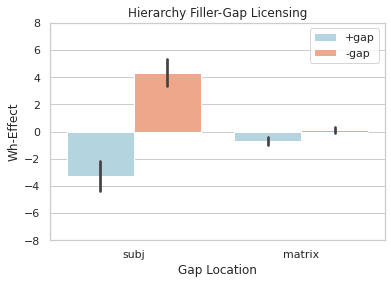

In [135]:
hierarchyResults = getHierarchy()
plotHierarchy(hierarchyResults)

# Unboundedness

I draw on the experiments detailed in [Wilcox et al. (2019)](https://cogsci.mindmodeling.org/2019/papers/0219/), which like the other paper, explored the relationship between syntactic depth and their wh-effect. 

In [85]:
#@title Unbounded Code
def getUnbounded(modelType='gpt2', modelName='gpt2'):
    # set path
    import sys
    import json
    sys.path.append("/content/PublicModelsAPI/")
    from src.models import models

    run_config = {'models': {modelType: [modelName]}}

    LM = models.load_models(run_config)[0]
    
    RESULTS = {'exp': [], 'item': [], 'cond': [], "wh-effect":[]}

    data = pd.read_csv("/content/TopicsCL/data/Wilcox/unbounded.tsv", sep='\t')

    # Filter out extra condition
    conditions = list(set(data['condition'].tolist()))
    goals = list(filter(lambda x: 'goal' in x, conditions))
    conditions = list(filter(lambda x: 'goal' not in x, conditions))

    data = data[~data.condition.isin(goals)]

    # no-gap object region
    # gap temporal_modifier region
    for index in range(21):
        vals = {}
        subset = data[data['sent_index'] == index]
        for cond in conditions:

            targetRegion = 'temporal_modifier'
            if 'no-gap' in cond:
                targetRegion='object'
            sentData = subset[subset['condition'] == cond]
            words = sentData['word'].tolist()
            regions = sentData['region'].tolist()
            assert len(words) == len(regions)
            regions = list(zip(regions, words))

            sent = ' '.join(words)

            # Get by word surprisals
            surps = LM.get_aligned_words_surprisals(sent)[0]
            
            # Group into regions
            total = 0
            for region in regions:
                r, w = region
                surp = surps.pop(0)
                assert surp.word == w
                if r == targetRegion:
                    total += surp.surp
            vals[cond] = total

        #calculate wh-effects
        gap_wh_effect_noemb = vals['wh_gap_obj_no-emb'] - vals['that_gap_obj_no-emb']
        nogap_wh_effect_noemb = vals['wh_no-gap_obj_no-emb'] - vals['that_no-gap_obj_no-emb']

        gap_wh_effect_emb1 = vals['wh_gap_obj_emb1'] - vals['that_gap_obj_emb1']
        nogap_wh_effect_emb1 = vals['wh_no-gap_obj_emb1'] - vals['that_no-gap_obj_emb1']

        gap_wh_effect_emb2 = vals['wh_gap_obj_emb2'] - vals['that_gap_obj_emb2']
        nogap_wh_effect_emb2 = vals['wh_no-gap_obj_emb2'] - vals['that_no-gap_obj_emb2']

        gap_wh_effect_emb3 = vals['wh_gap_obj_emb3'] - vals['that_gap_obj_emb3']
        nogap_wh_effect_emb3 = vals['wh_no-gap_obj_emb3'] - vals['that_no-gap_obj_emb3']

        gap_wh_effect_emb4 = vals['wh_gap_obj_emb4'] - vals['that_gap_obj_emb4']
        nogap_wh_effect_emb4 = vals['wh_no-gap_obj_emb4'] - vals['that_no-gap_obj_emb4']


        RESULTS['item'].extend([index]*10)


        RESULTS['exp'].extend([0,0,1,1,2,2,3,3,4,4])

        RESULTS['cond'].extend(['+gap', '-gap']*5)

        RESULTS['wh-effect'].append(gap_wh_effect_noemb)
        RESULTS['wh-effect'].append(nogap_wh_effect_noemb)

        RESULTS['wh-effect'].append(gap_wh_effect_emb1)
        RESULTS['wh-effect'].append(nogap_wh_effect_emb1)

        RESULTS['wh-effect'].append(gap_wh_effect_emb2)
        RESULTS['wh-effect'].append(nogap_wh_effect_emb2)

        RESULTS['wh-effect'].append(gap_wh_effect_emb3)
        RESULTS['wh-effect'].append(nogap_wh_effect_emb3)

        RESULTS['wh-effect'].append(gap_wh_effect_emb4)
        RESULTS['wh-effect'].append(nogap_wh_effect_emb4)

    return pd.DataFrame.from_dict(RESULTS)


In [83]:
#@title Plot Unbounded Results
def plotUnbounded(results):
    
    import seaborn as sns
    import matplotlib.pyplot as plt

    %matplotlib inline

    sns.set(style='whitegrid', color_codes=True)

    basicPlot = sns.barplot(data=results, 
                            x = 'exp', 
                            y = 'wh-effect', 
                            hue = 'cond', 
                            ci=95,
                            palette=['lightblue', 'lightsalmon'])
    basicPlot.set(ylim=(-8, 8))
    basicPlot.set(xlabel="Layers of Embedding", ylabel='Wh-Effect', 
                title="Unbounded Filler-Gap Licensing")

    basicPlot.legend(title='')

    plt.show()

Running on cpu
Using pad_token, but it is not set yet.
Pad token was set


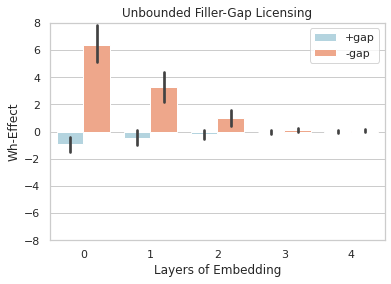

In [86]:
unboundedResults = getUnbounded()
plotUnbounded(unboundedResults)